# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import importlib
import time
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import ddpg_agent
RANDOM_SEED = 42

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64', seed=RANDOM_SEED)

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -7.79496002e+00  -1.00000000e+00
   1.79960966e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   1.64491057e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Instantiate the Agent

In [7]:
agent = ddpg_agent.Agent(state_size=state_size, action_size=action_size, random_seed=42)

### 6. Train the Agent with DDPG  

Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.00	Score: 0.00
Episode 400	Average Score: 0.00	Score: 0.00
Episode 500	Average Score: 0.00	Score: 0.00


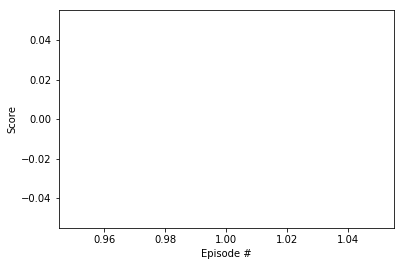

In [9]:
# From the pendulum code
def ddpg_Udacity(n_episodes=500, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    max_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations 
            rewards = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, rewards, next_state, done)
            state = next_state
            score += rewards
            if done:
                break 
        scores_deque.append(score)
        np.concatenate((scores, score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score.mean()), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
    return scores

agent = ddpg_agent.Agent(state_size=state_size, action_size=action_size, random_seed=42)
scores = ddpg_Udacity()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
# Modified from Navigation

def ddpg(n_episodes=175, max_t=500, scores_window_len=100, agent_name=ddpg_agent, 
         goal_score = 30, verbose=1):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        scores_window_len: a rolling window size for averaging the scores
        goal_score: the minimum average score required for a satisfactory model
        verbose: 0-No output, 1-Score output
    """
    # create an agent
    agent = agent_name.Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)
    
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=scores_window_len) # last however many scores        
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, add_noise=True)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0] 
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score) # save most recent score
        scores.append(score) # save most recent score
        if verbose >=1:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % scores_window_len == 0:
            if verbose >=1: 
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=goal_score:
            if verbose >=1:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                      .format(i_episode-scores_window_len, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [11]:
def print_hyperparameters(agent=None):
# Print out the dqn_agent hyperparameters
    if agent is not None:
        print('BUFFER_SIZE = {}'.format(agent.BUFFER_SIZE))
        print('BATCH_SIZE = {}'.format(agent.BATCH_SIZE))
        print('GAMMA = {}'.format(agent.GAMMA))
        print('TAU = {}'.format(agent.TAU))
        print('LR_ACTOR = {}'.format(agent.LR_ACTOR))
        print('LR_CRITIC = {}'.format(agent.LR_CRITIC))
        print('WEIGHT_DECAY = {}\n'.format(agent.WEIGHT_DECAY))
    return None

In [12]:
def plot_scores(scores, rolling_window=10, title = 'Scores'):
    """ Plots the scores and a rolling average"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    return None

In [13]:
def generate_scores(n_episodes=175, max_t=500, scores_window_len=100, agent=None,
                    goal_score = 30, verbose=1, plot=False, title='Scores'):
    """ Generates scores using the agent.  
        Attempts to make hyperparameter tuning easier
        Updates for the changes in the dqn_agent.py file 
        scores_window_len: a rolling window size for averaging the scores
        goal_score: the minimum average score required for a satisfactory model
        verbose: 0-No output, 1-Score and Time Elapsed, 2-Score, Time Elapsed and Hyperparameter
        plot: whether or not to plot the scores
        title: plot title
    """
    
    # reload library after modifying Hyperparameters
    importlib.reload(agent)

    # Generate Scores
    tic = time.time()
    if verbose == 2:
        print_hyperparameters(agent)       
    scores = ddpg(n_episodes=n_episodes, scores_window_len=scores_window_len, agent_name=agent,
                 goal_score=goal_score, verbose=verbose)
    toc = time.time()
    if verbose >=1:
        print("\nTime elapsed: {:.0f} seconds".format(toc-tic))

    # Plot Scores
    if plot == True:
        plot_scores(scores, rolling_window=scores_window_len, title=title)

    return scores

In [ ]:
_ = generate_scores(n_episodes=175, max_t=50, scores_window_len=100, agent=ddpg_agent,
                    goal_score = 30, verbose=2, 
                    plot=True, title='Default/Initial Hyperparameters')

BUFFER_SIZE = 1000000
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.001
LR_ACTOR = 0.0001
LR_CRITIC = 0.0003
WEIGHT_DECAY = 0.0001

Episode 4	Average Score: 0.00

When finished, you may close the environment

In [ ]:
# env.close()